In [1]:
from google.colab import files
uploaded=files.upload()

Saving xy_data.csv to xy_data.csv


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

fname = list(uploaded.keys())[0]
df = pd.read_csv(fname)
df.head()

,x,y
0,88.364456,57.784378
1,74.283936,54.406780
2,60.256474,46.311462
3,82.134370,57.717567
4,101.036390,67.849340


In [ ]:
T_MIN, T_MAX = 6.0, 60.0

def estimate_t_from_polyline(x, y, t_min=6.0, t_max=60.0):
    dx = np.diff(x); dy = np.diff(y)
    seg = np.sqrt(dx*dx + dy*dy)
    s = np.concatenate([[0.0], np.cumsum(seg)])
    if s[-1] == 0:
        t = np.linspace(t_min, t_max, len(x))
    else:
        t = t_min + (t_max - t_min) * (s / s[-1])
    return t

t_obs = estimate_t_from_polyline(x_obs, y_obs, T_MIN, T_MAX)
print("t range:", float(t_obs.min()), float(t_obs.max()))


t range: 6.0 60.0


In [ ]:
def model_xy(t, theta, M, X):
    # x(t) = t cosθ − e^{M|t|} sin(0.3 t) sinθ + X
    # y(t) = 42 + t sinθ + e^{M|t|} sin(0.3 t) cosθ
    exp_term = np.exp(M*np.abs(t))*np.sin(0.3*t)
    x = t*np.cos(theta) - exp_term*np.sin(theta) + X
    y = 42.0 + t*np.sin(theta) + exp_term*np.cos(theta)
    return x, y


In [ ]:
def l1_loss(params, t, x_true, y_true):
    theta, M, X = params
    x_pred, y_pred = model_xy(t, theta, M, X)
    return np.sum(np.abs(x_pred - x_true) + np.abs(y_pred - y_true))


In [ ]:
from scipy.optimize import differential_evolution, minimize

deg2rad = np.pi/180.0
bounds = [
    (0.0*deg2rad, 50.0*deg2rad),
    (-0.05, 0.05),
    (0.0, 100.0),
]


res_de = differential_evolution(
    lambda p: l1_loss(p, t_obs, x_obs, y_obs),
    bounds=bounds,
    strategy="best1bin", popsize=25, maxiter=300, tol=1e-7,
    seed=42, polish=True
)

res_nm = minimize(
    l1_loss, res_de.x, args=(t_obs, x_obs, y_obs),
    method="Nelder-Mead",
    options=dict(maxiter=5000, xatol=1e-9, fatol=1e-9)
)

if res_nm.fun < res_de.fun:
    best = res_nm
else:
    best = res_de

theta_hat, M_hat, X_hat = map(float, best.x)
best_loss = float(best.fun)

print("θ(rad), M, X =", theta_hat, M_hat, X_hat)
print("θ(deg) =", theta_hat/deg2rad)
print("L1 loss on observed points =", best_loss)


θ(rad), M, X = 0.48813330748591943 0.020501646354460334 54.66619494266074
θ(deg) = 27.967978358704855
L1 loss on observed points = 37923.93297692886


In [ ]:
expr = (
    f"\\left(t*\\cos({theta_hat:.6f})"
    f"-e^{{{M_hat:.6f}\\left|t\\right|}}\\cdot\\sin(0.3t)\\sin({theta_hat:.6f})+{X_hat:.6f},"
    f"42+t*\\sin({theta_hat:.6f})+e^{{{M_hat:.6f}\\left|t\\right|}}\\cdot\\sin(0.3t)\\cos({theta_hat:.6f})\\right)"
)


print(expr)
print("\n(also report)  θ (deg):", theta_hat/deg2rad, "   M:", M_hat, "   X:", X_hat)


\left(t*\cos(0.488133)-e^{0.020502\left|t\right|}\cdot\sin(0.3t)\sin(0.488133)+54.666195,42+t*\sin(0.488133)+e^{0.020502\left|t\right|}\cdot\sin(0.3t)\cos(0.488133)\right)

(also report)  θ (deg): 27.967978358704855    M: 0.020501646354460334    X: 54.66619494266074


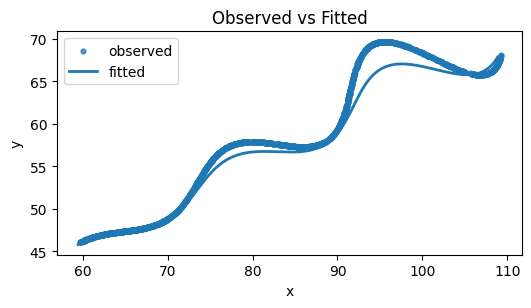

In [ ]:
x_fit, y_fit = model_xy(t_obs, theta_hat, M_hat, X_hat)

plt.figure(figsize=(6,6))
plt.scatter(x_obs, y_obs, s=12, label="observed", alpha=0.75)
plt.plot(x_fit, y_fit, lw=2, label="fitted")
plt.gca().set_aspect('equal', adjustable='box')
plt.xlabel("x"); plt.ylabel("y"); plt.title("Observed vs Fitted")
plt.legend(); plt.show()


In [ ]:
from bisect import bisect_left

def score_uniform_L1(theta, M, X, t_min=6.0, t_max=60.0, N=500):
    t_uni = np.linspace(t_min, t_max, N)
    xp, yp = model_xy(t_uni, theta, M, X)


    idx = np.abs(t_obs[:,None] - t_uni[None,:]).argmin(axis=0)
    x_true = x_obs[idx]
    y_true = y_obs[idx]
    return np.sum(np.abs(xp - x_true) + np.abs(yp - y_true))

uniform_L1 = score_uniform_L1(theta_hat, M_hat, X_hat)
print("L1 distance (approx):", uniform_L1)


L1 distance (approx): 13932.83239293922
